In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from stochastic_simulation import StochasticSimulation
from sir_stochastic_sim import SIRStochasticSimulation

In [2]:
def sim_many_test_days(base_params, test_days, use_SIR_dynamics=False, time_horizon=250, only_bucket_test=True):
    dfs_cts = {}
    dfs_bucket = {}
    base_params_cts = base_params.copy()
    base_params_cts['days_between_tests'] = 1
    
    base_params_bucket = base_params.copy()
    base_params_bucket['test_population_fraction'] = 1
    
    for T in test_days:
        if not only_bucket_test:
            base_params_cts['test_population_fraction'] = 1/T
            if use_SIR_dynamics:
                sim_cts = SIRStochasticSimulation(base_params_cts)
            else:
                sim_cts = StochasticSimulation(base_params_cts)
            dfs_cts[T] = []
            for _ in range(100):
                dfs_cts[T].append(sim_cts.run_new_trajectory(time_horizon))
        
        base_params_bucket['days_between_tests'] = T
        if use_SIR_dynamics:
            sim_bucket = SIRStochasticSimulation(base_params_bucket)
        else:
            sim_bucket = StochasticSimulation(base_params_bucket)
        dfs_bucket[T] = []
        for _ in range(100):
            dfs_bucket[T].append(sim_bucket.run_new_trajectory(time_horizon))
        
        print("Done test frequency {}".format(T))
    
    return dfs_cts, dfs_bucket

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12

def add_plot(df, params, color='blue', ID_only=False):
    if ID_only:
        cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])]
    else:
        cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])] + \
                ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + ['R']
    popsize = df.iloc[0].sum()
    plt.plot(df[cols].sum(axis=1) / popsize, linewidth=10.0, alpha=0.1, color=color)    


# just need params to get the proper column names
def plot_sims(dfs1, dfs2, title1, title2, params, ID_only=False):
    plt.figure(figsize=(20,12))

    plt.subplot(2,1,1)
    
    plt.xlabel("Day")
    plt.ylabel("Number of Active Infections")
    plt.title(title1)

    for df in dfs1:
        add_plot(df, params, ID_only=ID_only)

    plt.subplot(2,1,2)
    plt.xlabel("Day")
    plt.ylabel("Number of Active Infections")
    plt.title(title2)
    for df in dfs2:
        add_plot(df, params, color='green', ID_only=ID_only)

    plt.show()

def plot_many_sims(dfs_cts, dfs_bucket, params, ID_only):
    for test_frequency in dfs_cts.keys():
        df_cts = dfs_cts[test_frequency]
        df_bucket = dfs_bucket[test_frequency]
        title_cts = "Trajectory Under Continuous Testing: Test 1/{} Population Every Day".format(test_frequency)
        title_bucket = "Trajectory Under Bucket Testing: Test Everyone Every {} Days".format(test_frequency)
        plot_sims(df_cts, df_bucket, title_cts, title_bucket, params, ID_only)

In [24]:
import numpy as np
from scipy.stats import geom, poisson

import functools

@functools.lru_cache(maxsize=128)
def poisson_pmf(max_time, mean_time):
    pmf = list()
    if mean_time == 0:
        return [1] + [0] * max_time
    for i in range(max_time):
        if i == 0:
            pmf.append(0)
        else:
            pmf.append(geom.pmf(i, 1/mean_time))
    pmf.append(1-np.sum(pmf))
    return np.array(pmf)



In [25]:
poisson_pmf(30, 10)

array([0.        , 0.1       , 0.09      , 0.081     , 0.0729    ,
       0.06561   , 0.059049  , 0.0531441 , 0.04782969, 0.04304672,
       0.03874205, 0.03486784, 0.03138106, 0.02824295, 0.02541866,
       0.02287679, 0.02058911, 0.0185302 , 0.01667718, 0.01500946,
       0.01350852, 0.01215767, 0.0109419 , 0.00984771, 0.00886294,
       0.00797664, 0.00717898, 0.00646108, 0.00581497, 0.00523348,
       0.04710129])

In [32]:
# Set parameters (no CT, testing)
base_params = {
    'max_time_exposed': 4,
    'exposed_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=4, mean_time=0))),
    
    'max_time_pre_ID': 4,
    'pre_ID_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=4, mean_time=0))),
    
    'max_time_ID': 30,
    'ID_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=30, mean_time=10))),
    
    'max_time_SyID_mild': 1,
    'SyID_mild_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=1, mean_time=0))),
    
    'max_time_SyID_severe': 1,
    'SyID_severe_time_function': (lambda n: np.random.multinomial(n, poisson_pmf(max_time=1, mean_time=0))),
    
    'sample_QI_exit_function': (lambda n: np.random.binomial(n, 0.05)),
    'sample_QS_exit_function': (lambda n: np.random.binomial(n, 0.3)),
    
    'exposed_infection_p': 0.026,
    'expected_contacts_per_day': 10/2.6,
    
    'mild_symptoms_p': 0.4,
    'mild_symptoms_daily_self_report_p': 0.15,
    'severe_symptoms_daily_self_report_p': 0.85,
    
    'days_between_tests': 10,
    'test_population_fraction': 0,
    
    'test_protocol_QFNR': 0.1,
    'test_protocol_QFPR': 0.005,
    
    'perform_contact_tracing': False,
    'contact_tracing_constant': 0.7,
    'contact_tracing_delay': 1,
    'contact_trace_infectious_window': 8,
    
    'pre_ID_state': 'detectable',
    
    'population_size': 200000*10000000000,
    'initial_E_count': 0,
    'initial_pre_ID_count': 0,
    'initial_ID_count': 200*10000000000,
    'initial_SyID_mild_count': 0,
    'initial_SyID_severe_count': 0
}


In [33]:
# Calculate expected R0

avg_days_I_free = 10
R0 = avg_days_I_free * 10/2.6 * 0.026

In [34]:
print(R0)

0.9999999999999999


In [38]:
# Simulate
sim = StochasticSimulation(base_params)
dfs_cts_seir_8_trace, dfs_bucket_seir_8_trace = sim_many_test_days(base_params=base_params, 
                                                       test_days=[300], 
                                                       use_SIR_dynamics=False, time_horizon=100, only_bucket_test=True)

Done test frequency 300


In [39]:
# Fine expected trajectory given R0 (how to do this? - average serial period?)

alpha = np.exp((R0 - 1)/(avg_days_I_free))
time = list()
count = list()

for t in range(10+1):
    time.append(t)
    count.append(200000000*(alpha**t))

# Old way
'''
time = list()
count = list()
time.append(0)
count.append(200)
time_now = 0
while(time_now < 50):
    time_now += avg_days_I_free + 4
    time.append(time_now)
    count.append(min(count[-1]*(R0+1),200000))
'''
# Expected time between infections = avg_days_I_free / 2

'\ntime = list()\ncount = list()\ntime.append(0)\ncount.append(200)\ntime_now = 0\nwhile(time_now < 50):\n    time_now += avg_days_I_free + 4\n    time.append(time_now)\n    count.append(min(count[-1]*(R0+1),200000))\n'

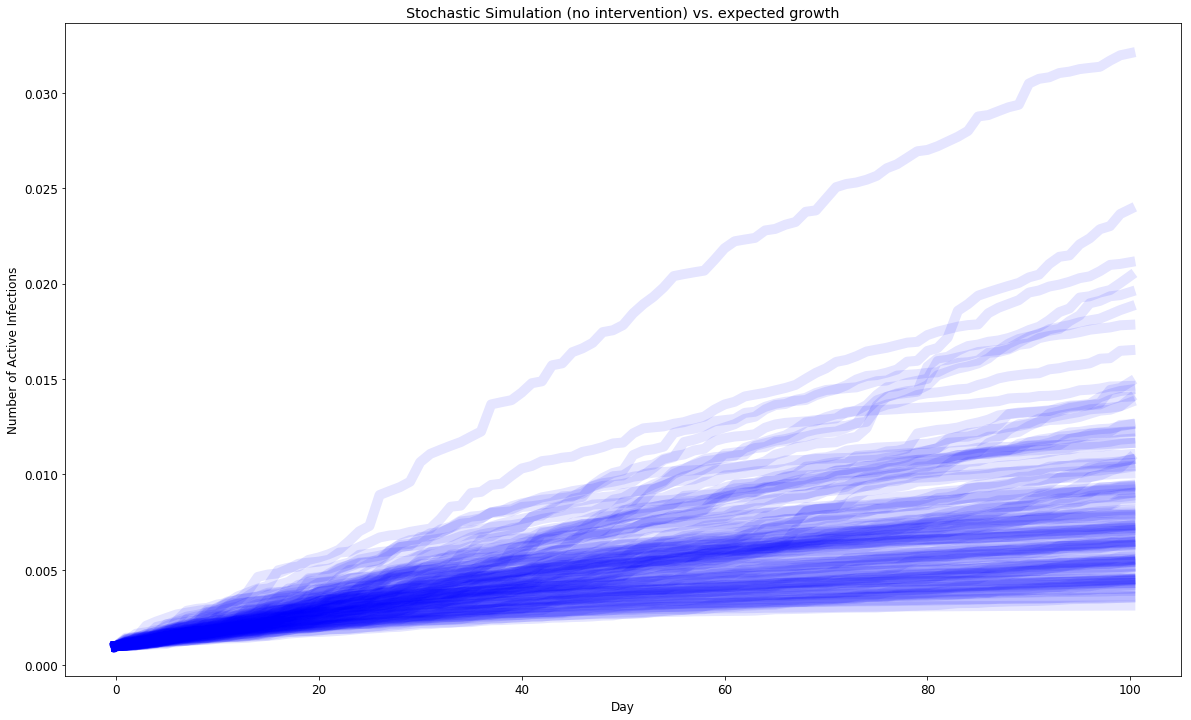

In [40]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(20,12))
plt.xlabel("Day")
plt.ylabel("Number of Active Infections")
plt.title('Stochastic Simulation (no intervention) vs. expected growth')

dfs1 = dfs_bucket_seir_8_trace[300]

for df in dfs1:
    add_plot(df, base_params, ID_only=False)
#plt.plot(time, count, 'o', color='red');

In [41]:
base_params['expected_contacts_per_day'] *= 1.2

In [42]:
# Simulate
sim = StochasticSimulation(base_params)
dfs_cts_seir_8_trace, dfs_bucket_seir_8_trace = sim_many_test_days(base_params=base_params, 
                                                       test_days=[300], 
                                                       use_SIR_dynamics=False, time_horizon=100, only_bucket_test=True)

Done test frequency 300


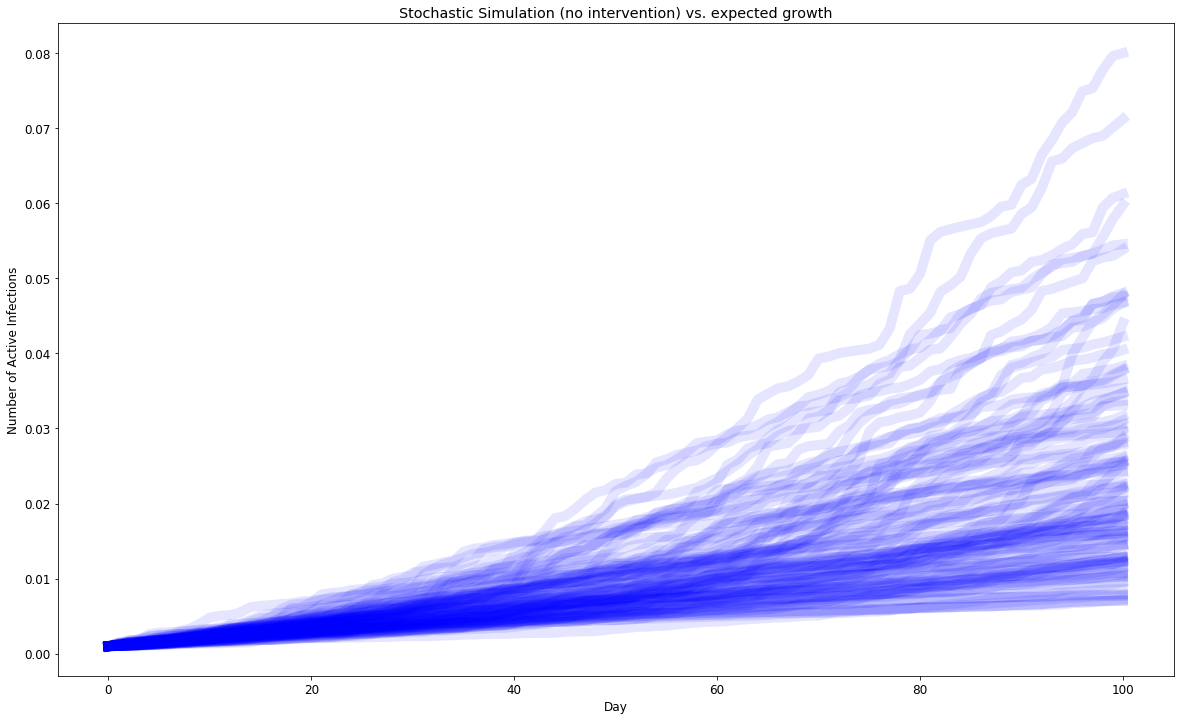

In [43]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(20,12))
plt.xlabel("Day")
plt.ylabel("Number of Active Infections")
plt.title('Stochastic Simulation (no intervention) vs. expected growth')

dfs1 = dfs_bucket_seir_8_trace[300]

for df in dfs1:
    add_plot(df, base_params, ID_only=False)
#plt.plot(time, count, 'o', color='red');

In [69]:
dfs1[0]

,S,QS,QI,R,E_0,E_1,E_2,E_3,pre_ID_0,pre_ID_1,...,ID_22,ID_23,ID_24,ID_25,ID_26,ID_27,ID_28,ID_29,SyID_mild_0,SyID_severe_0
0,199800000000,0,0,0,0,0,0,0,0,0,...,1968816,1773881,1596216,1435771,1291784,1161775,1047126,9427181,0,0
1,199748056765,0,0,19996062,0,0,0,0,0,0,...,2284745,2056345,1850585,1664827,1497266,1348314,9699011,2447764,0,0
2,199687823357,0,0,43182896,0,0,0,0,0,0,...,2650621,2384410,2145759,1930280,1736705,10048747,2763238,2837489,0,0
3,199617985377,0,0,70085081,0,0,0,0,0,0,...,3072835,2765405,2487060,2236525,10500109,3169708,3203100,3290082,0,0
4,199537023883,0,0,101285865,0,0,0,0,0,0,...,3563290,3205116,2882627,11080024,3692415,3673183,3713587,3814439,0,0
5,199443198814,0,0,137455435,0,0,0,0,0,0,...,4129288,3714285,11828514,4365778,4279099,4260034,4305744,4420048,0,0
6,199334475083,0,0,179381200,0,0,0,0,0,0,...,4785142,12791666,5232476,5058994,4963088,4938208,4988434,5124629,0,0
7,199208486357,0,0,228000436,0,0,0,0,0,0,...,14033000,6349089,6064975,5868656,5753678,5721233,5782702,5934436,0,0
8,199062545314,0,0,284343788,0,0,0,0,0,0,...,7786192,7356926,7032714,6801512,6662804,6632452,6697347,6873121,0,0
9,198893536920,0,0,349655043,0,0,0,0,0,0,...,9020635,8532650,8148532,7874602,7723625,7680511,7756921,7963727,0,0


In [44]:
alpha

1.1561958023875578

In [33]:
print(R0)

2.2635294117647056
